In [64]:
import torch
import torch.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#first commit
# num matrices * batchsize * num inputs
X = torch.rand(5, 2, 3)
X

tensor([[[0.9833, 0.6632, 0.4742],
         [0.1435, 0.6430, 0.6656]],

        [[0.6432, 0.5328, 0.9737],
         [0.7002, 0.3821, 0.9564]],

        [[0.8057, 0.5669, 0.9567],
         [0.6552, 0.1155, 0.5405]],

        [[0.2808, 0.0602, 0.0441],
         [0.4063, 0.5970, 0.6871]],

        [[0.2798, 0.0726, 0.4740],
         [0.3166, 0.7893, 0.8192]]])

In [28]:
# Import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

In [103]:
# Create the Deep Learning Model
def createTheNet(printtoggle, input_size, num_hidden, num_layers, actfun, bias, batchsize):
    class rnnClassNet(nn.Module):
        def __init__(self, input_size, num_hidden, num_layers, actfun, bias, batchsize):
            
            super().__init__()
            self.printT = printtoggle
            
            # Store Parameters
            self.input_size = input_size
            self.num_hidden = num_hidden
            self.num_layers = num_layers
            self.actfun = actfun
            self.bias = bias
            self.batchsize = batchsize
            
            # # # ----- RNN layers ------ # # #
            # nn.RNN(input_size, num_hidden)
            self.rnn = nn.RNN(input_size, num_hidden,  num_layers,
                              nonlinearity= self.actfun, bias=self.bias)
            
            # # # ----- linear layer ------ # # #
            self.out = nn.Linear(num_hidden, 1)
            
        def forward(self,x):
            
            # initialize hidden state for first input
            hidden = torch.zeros(self.num_layers, self.batchsize, self.num_hidden)
            if self.printT: print(f'Hidden: {list(hidden.shape)}')
            
            # run through the RNN layer
            y, hidden = self.rnn(x, hidden)
            if self.printT: print(f'RNN-out: {list(y.shape)}')
            if self.printT: print(f'RNN-Hidden: {list(hidden.shape)}')
            
            # pass the rnn output through linear layer
            o = self.out(y)
            if self.printT: print(f'Output: {list(o.shape)}')
            
            return o, hidden
    
    modelInstance = rnnClassNet(input_size, num_hidden, num_layers, actfun, bias, batchsize)

    lossfun = nn.MSELoss()
    
    optimizer = torch.optim.SGD(modelInstance.parameters(), lr=0.001)
    
    return modelInstance, lossfun, optimizer

In [104]:
# network parameters
input_size = 1  # channels/features of data
num_hidden = 16 # breadth of model (number of hidden layers)
num_layers = 1  # depth of model   (number of stacks of hidden layers)
seqlength  = 9  # num of data points used for learning in each segment 
batchsize  = 1  # number of batches of selength
actfun = 'tanh'
bias = True
#N = 50          # number of data units

In [105]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True, input_size, num_hidden, num_layers, actfun, bias, batchsize)
print(net2)

#check all learnable parameters
for p in net2.named_parameters():
    print(f'{p[0]} has size {list(p[1].shape)}')

rnnClassNet(
  (rnn): RNN(1, 16)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
rnn.weight_ih_l0 has size [16, 1]
rnn.weight_hh_l0 has size [16, 16]
rnn.bias_ih_l0 has size [16]
rnn.bias_hh_l0 has size [16]
out.weight has size [1, 16]
out.bias has size [1]


In [106]:
# test the model with some data
# convert 1d array into tensor
# X = data[:seqlength].view(seqlength, 1, 1)

num_outputs = 1
X = torch.rand(seqlength, batchsize, input_size)
y = torch.rand(seqlength, batchsize, num_outputs)
yHat, h = net2(X)

# try a loss function
lossfun = nn.MSELoss()
lossfun(yHat, y)


Hidden: [1, 1, 16]
RNN-out: [9, 1, 16]
RNN-Hidden: [1, 1, 16]
Output: [9, 1, 1]


tensor(0.5104, grad_fn=<MseLossBackward0>)

In [107]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=30):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc    = torch.zeros(numepochs)
    testLoss    = torch.zeros(numepochs)
    testAcc     = torch.zeros(numepochs)

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainSegLoss = []
        trainSegAcc  = []
        hidden_state = torch.zeros(num_layers, batchsize, num_hidden) # reset the hidden state
        
        #loop over data segments / sequences
        for timei in range(N-seqlength):
            
            # Grab a snippet of data
            X = data[timei:timei+seqlength].view(seqlength, batchsize, input_size)
            y = data[timei+seqlength].view(batchsize, 1)
            
            # push data to GPU
            # X = X.to(device)
            # y = y.to(device)
            
            #Forward pass & loss
            yHat, hidden_state = trainedModel(X)
            finalValue = yHat[-1]
            loss = lossfun(finalValue, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainSegLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            # trainTrueSign = np.sign(torch.squeeze(y).numpy()) ##
            # trainPredSign = np.sign(torch.squeeze(finalValue).detach().numpy())##
            # trainSegAcc.append( 100*(trainTrueSign == trainPredSign) )
            trainTrueSign = torch.sign(y) ##
            trainPredSign = torch.sign(finalValue) ##
            trainSegAcc.append( 100*(trainTrueSign == trainPredSign) )
        
        #average accuracy across mini-batches
        # trainAcc[epochi]  = np.mean(trainSegAcc)
        trainAcc[epochi]  = torch.tensor(trainSegAcc).float().mean()
        
        #average losses across all mini-batches
        # trainLoss[epochi] = np.mean(trainSegLoss)
        trainLoss[epochi] = torch.tensor(trainSegLoss).float().mean()
        
    return trainAcc, trainLoss, trainedModel

In [108]:
# Test the training code that it has NO ERRORS
epochs=1
myModelInstance2, lossfun2, optimizer2 = createTheNet(False, input_size, num_hidden, num_layers, actfun, bias, batchsize)
trainAcc2, trainLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

In [109]:
# Train the Model
myModelInstance, lossfun, optimizer = createTheNet(False, input_size, num_hidden, num_layers, actfun, bias, batchsize)
trainAcc, trainLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)


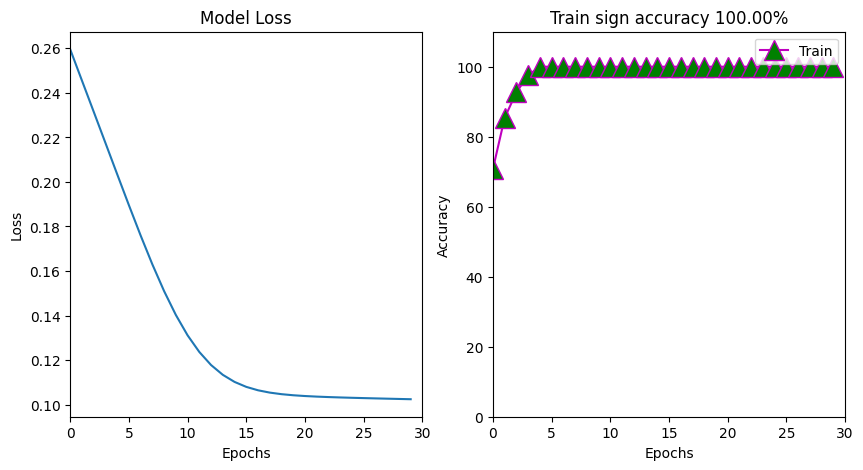

In [110]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlim([0,30])

ax[1].plot(trainAcc, 'm^-', markerfacecolor='g', markersize=15, label='Train')
# ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train sign accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
ax[1].set_xlim([0,30])

plt.show()